## Imports and auxiliar functions


In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
from skimage.transform import radon, iradon
import matplotlib.pyplot as plt

import time

def get_mgrid(length1, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=length1)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

def plot_images(original, transformed, num_realizations):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Shepp-Logan Phantom')

    plt.subplot(1, 3, 2)
    plt.imshow(transformed, cmap='gray', extent=(0, 180, 0, num_realizations), aspect='auto')
    plt.title('Radon Transform')
    plt.xlabel('Projection Angle (degrees)')
    plt.ylabel('Realizations')

    reconstructed = iradon(transformed, theta=np.linspace(0., 180., transformed.shape[1]), circle=True)
    plt.subplot(1, 3, 3)
    plt.imshow(reconstructed, cmap='gray')
    plt.title('Reconstructed Image')

    plt.show()

def plot_images2(img, mse, psnr):

    #diff = np.abs(img - past_img)

    plt.figure(figsize=(14, 4))


    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray_r')
    plt.colorbar()
    plt.title('Image')

    # plt.subplot(1, 4, 2)
    # plt.imshow(diff, cmap='viridis', aspect='auto')
    # # Add colorbar for reference
    # plt.colorbar()
    # plt.title('Diff')

    plt.subplot(1, 3, 2)
    plt.plot(range(1,len(mse)+1), mse)
    plt.title('MSE')

    plt.subplot(1, 3, 3)
    plt.plot(range(1,len(psnr)+1), psnr)
    plt.title('PSNR')

    plt.show()

def radon_transform(image, num_angles):
    angles = torch.linspace(0.0, 180.0, steps=num_angles)
    radon_images = []
    for angle in angles:
        rotated_image = TF.rotate(image.unsqueeze(0), angle.item())
        projection = torch.sum(rotated_image.squeeze(0), dim=0)
        radon_images.append(projection)

    return torch.stack(radon_images, dim=0)

def get_img_tensor(im, length1):
    img = Image.fromarray(im)
    transform = Compose([
        Resize((length1)),
        ToTensor(),
        #Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

def psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    #max_pixel_value = torch.max(img2)
    max_pixel_value = 1
    #print(max_pixel_value)
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    return psnr.item()

def normalize(data):
    max = data.max()
    min = data.min()
    return (data-min)/(max-min)

#Mean Structural Similarity Index Map
def mssim(img1, img2, alpha, beta, gamma):
    """Return the Structural Similarity Map corresponding to input images img1
    and img2
    """

    # Convert to float64 to avoid floating point error and negative values in sigma1_sq or sigma2_sq
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    # Data range
    L = np.max(img2) - np.min(img2)

    # Parameters from Wang et al. 2004
    sigma = 1.5
    K1 = 0.01
    K2 = 0.03
    C1 = (K1*L)**2
    C2 = (K2*L)**2

    # Convolve images (gaussian or uniform filter) to get mean for each patch
    filter_args = {'sigma': sigma, 'truncate': 3.5} # 3.5 is the number of sigmas to match Wang et al. to have filter size=11
    mu1 = gaussian(img1)
    mu2 = gaussian(img2)

    # Multiply images
    mu1_sq = mu1*mu1
    mu2_sq = mu2*mu2
    mu1_mu2 = mu1*mu2

    # Convolve images (gaussian or uniform filter) to get variance and covariance for each patch. Remove negative values coming from floating point errors

    sigma1_sq = gaussian(img1*img1) - mu1_sq
    sigma1_sq[sigma1_sq < 0] = 0
    sigma2_sq = gaussian(img2*img2) - mu2_sq
    sigma2_sq[sigma2_sq < 0] = 0
    sigma12 = gaussian(img1*img2) - mu1_mu2

    # Compute luminance, contrast and structure for each patch
    luminance =((2*mu1_mu2 + C1)/(mu1_sq + mu2_sq + C1))**alpha
    contrast=((2*np.sqrt(sigma1_sq*sigma2_sq) + C2)/(sigma1_sq + sigma2_sq + C2))**beta
    structure=((2*sigma12 + C2)/(2*np.sqrt(sigma1_sq*sigma2_sq) + C2))**gamma

    # Compute MSSIM
    MSSIM=np.mean(luminance*contrast*structure)
    return MSSIM

## Siren Model

In [ ]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

## Data Model

In [ ]:
class ImageFitting(Dataset):
    def __init__(self, img, length1):
        super().__init__()
        img = get_img_tensor(img, length1)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(length1, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0: raise IndexError

        return self.coords, self.pixels

## Initializing model and data

In [ ]:
# Establish seed for reproducibility
torch.manual_seed(42)

img = skimage.data.shepp_logan_phantom()

phantom = ImageFitting(img, 400)
dataloader = DataLoader(phantom, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=1, hidden_features=256,
                  hidden_layers=3, outermost_linear=True)
img_siren.cuda()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

## Running Model

Step 10, Total loss 0.026127


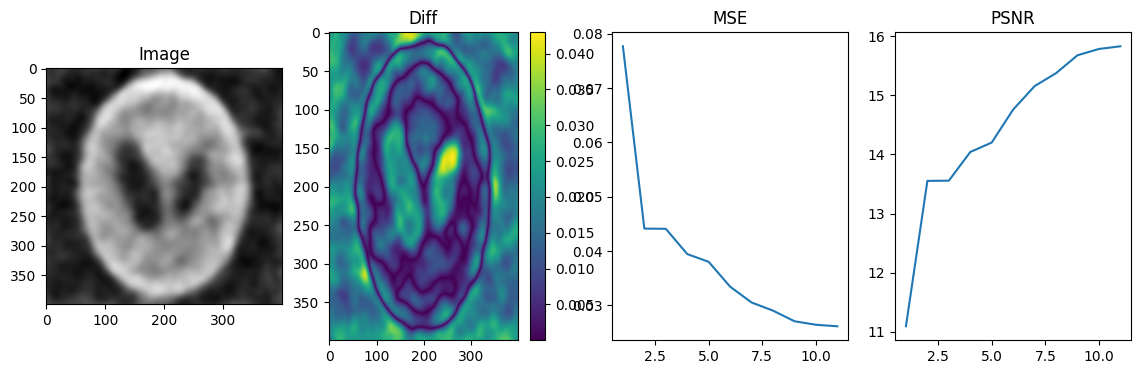

Step 20, Total loss 0.018843


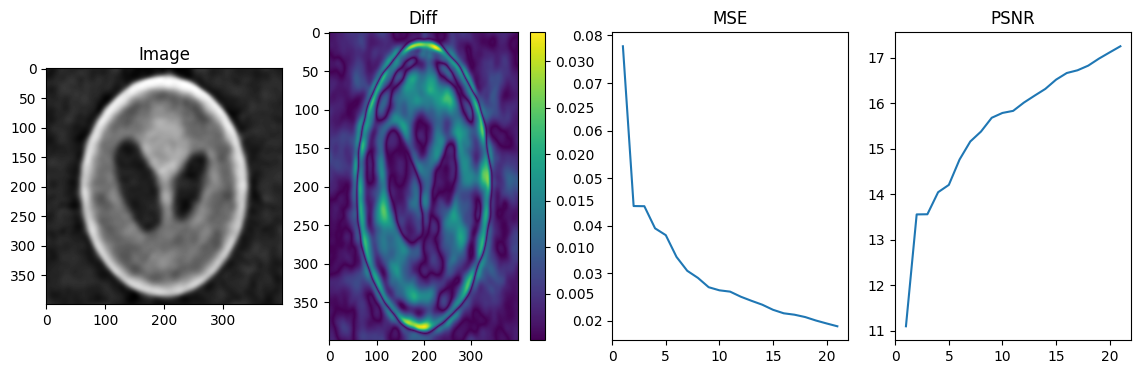

Step 30, Total loss 0.013406


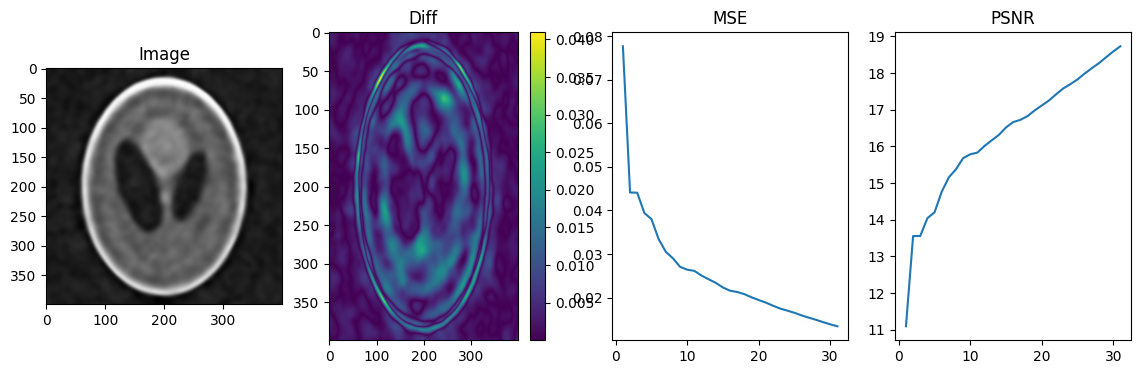

KeyboardInterrupt: 

In [ ]:
total_steps = 4001 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())
#optim = torch.optim.Adagrad(lr=1e-3, params=img_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

mse_losses = []
psnr_losses = []


for step in range(total_steps):

    if step >0 :
      past_output = model_output

    model_output, coords = img_siren.forward(model_input)



    mse_loss = ((model_output - ground_truth)**2).mean()
    psnr_loss = psnr(model_output, ground_truth)

    mse_losses.append(mse_loss.item())
    psnr_losses.append(psnr_loss)

    if step > 0 and not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, mse_loss))

        plot_images2(model_output.cpu().view(400,400).detach().numpy(), mse_losses, psnr_losses)

    optim.zero_grad()
    mse_loss.backward()
    optim.step()

In [ ]:
len(mse_losses)

4000

In [ ]:
min(mse_losses)

7.6074070420872886e-06

In [ ]:
max(psnr_losses)

51.1876335144043

In [ ]:
torch.max(sinog_tensor)

In [ ]:
torch.save(img_siren.state_dict(),'img_rec_1e4.pth')

In [ ]:
psnr_losses[3700:3725]

[50.623661041259766,
 50.623477935791016,
 50.62174987792969,
 50.617279052734375,
 50.60802459716797,
 50.5904426574707,
 50.558258056640625,
 50.50050735473633,
 50.39817428588867,
 50.21984100341797,
 49.91498565673828,
 49.413753509521484,
 48.630008697509766,
 47.50049591064453,
 46.00318145751953,
 44.22039794921875,
 42.26352310180664,
 40.36037826538086,
 38.70479202270508,
 37.70270538330078,
 37.746028900146484,
 39.67643356323242,
 44.841529846191406,
 48.768978118896484,
 42.75586700439453]